In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import gudhi as gd
from tqdm.notebook import tqdm  # For progressbar


from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import matplotlib
import seaborn as sns
sns.set_style("whitegrid")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams.update({'figure.autolayout': True})

In [2]:
# training
training_file = open('combined_training_info_with_radial_filtrations_9_21.pickle','rb')
training_data = pickle.load(training_file);
training_x = training_data.get('x_data');
training_y = training_data.get('y_data');
training_file.close();

# testing
testing_file = open('combined_testing_info_with_radial_filtrations_9_21.pickle','rb')
testing_data = pickle.load(testing_file);
testing_x = testing_data.get('x_data');
testing_y = testing_data.get('y_data');
testing_file.close();

In [3]:
# optionally reduce feature types during feature extraction
includeGraphFeatures = True;
includeSplineFeatures = False;
includeRadialFeatures = False;
numFeatures = 6

# retrieve features that are defined within this method for any graph that is passed as an argument.
adjustBetti = True
def get_graph_features(combined_data, graph_data, time_index, graph_type = 'water-water'):
    
    # retrieve only a slice of the full simulation time to match the density EC time frame
    start = time_index*200;
    end = (time_index+1)*200;
    
    # retrieve values that were directly extracted from the graph
    betti0 = graph_data.get('betti0')[start:end];
    numEdges = graph_data.get('numEdges')[start:end];
    numVertices= graph_data.get('numVertices')[start:end];
    numWaters = combined_data.get('numWaters');
    numCosolvents = combined_data.get('numCosolvents');
    
    # calculate some values based on those above to use as features
    euler_char = numVertices - numEdges;
    if (adjustBetti):
        if (graph_type == 'water-water'):
            euler_char = numVertices - numEdges;      
        elif (graph_type == 'solute-water'):
            euler_char = numEdges;          
        elif (graph_type == 'cosolvent-water'):
            euler_char = numEdges;          
        elif (graph_type == 'cosolvent-solute'):
            euler_char = numEdges;

    # calculate feature values and return
    vals = [np.mean(euler_char), np.std(euler_char)];
#     vals = [np.mean(euler_char)];
    
    return np.asarray(vals);

def get_all_features(combined_data, y_data):
    
    # variables relevant to every simulation in the set
    numSamples = len(combined_data)
    numTimePoints = combined_data[0].get('ec_data').shape[0]; 
    all_features = [];
    solutes = []
    cosolvents = []
    mass = []
    
    # iterate through each simluation
    for i in tqdm(range(numSamples)):
        
        features_for_sim = [];
        
        # retrieve the graphs for a particular simulation
        graph_ww = combined_data[i].get('water_water_data');
        graph_sw = combined_data[i].get('solute_water_data');
        graph_cw = combined_data[i].get('cosolvent_water_data');
        graph_cs = combined_data[i].get('cosolvent_solute_data');
        
        # for each time point (10) within a simulation:
        for j in range(numTimePoints):
            
            #obtain cosolvent and solute data
            solutes.append(combined_data[i].get('ec_dict').get('solute'))
            cosolvents.append(combined_data[i].get('ec_dict').get('cosolvent'))
            mass.append(combined_data[i].get('ec_dict').get('water_mass_frac'))    
            features_for_time_point = []
                       
            # graph features
            if (includeGraphFeatures):
                graph_features_ww = get_graph_features(combined_data[i], graph_ww, j, graph_type = 'water-water');
                graph_features_sw = get_graph_features(combined_data[i], graph_sw, j, graph_type = 'solute-water');
                graph_features_cw = get_graph_features(combined_data[i], graph_cw, j, graph_type = 'cosolvent-water');
                graph_features_cs = get_graph_features(combined_data[i], graph_cs, j, graph_type = 'cosolvent-solute');
                
                # decide which graph features to include in the final feature consolidation
                graph_features_all = np.concatenate((graph_features_ww, graph_features_sw, graph_features_cs));
                
                features_for_time_point.extend(graph_features_all);
                
            features_for_sim.append(features_for_time_point);
    
        all_features.append(features_for_sim);

    features = np.asarray(all_features);
        
    # reshape the y_values and the features
    y_data_duplicated = np.repeat(y_data,numTimePoints);
    features_2d = features.reshape( (numSamples*numTimePoints, numFeatures) );
    
    return features_2d, y_data_duplicated,solutes,cosolvents,mass;

In [4]:
x_train_g, y_train,train_solutes,train_cosolvents, train_water_percent = get_all_features(training_x, training_y);
x_test_g, y_test, test_solutes, test_cosolvents, test_water_percent = get_all_features(testing_x, testing_y);

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [5]:
#%% LOADING ALL INSTANCES
instances = np.load("MD_Training_Sets.pickle",allow_pickle = True)
test_instances = np.load("MD_Test_Sets.pickle",allow_pickle = True)

In [6]:
x_data = instances[0]
y_data = instances[1]
x_tdata = test_instances[0]
y_tdata = test_instances[1]

test_instances[2]

len(test_instances[2])

32

In [7]:
x_array = np.asarray(x_data)
x_tarray = np.asarray(x_tdata)

In [8]:
y_data = np.asarray(y_data)
y_tarray = np.asarray(y_tdata)

In [9]:
# returns an entire euler characteristic curve for a given time point over the full range of filtration values
def get_euler_characteristic(data,samples,instindx,y_data):
    curves = []
    filtration_increment = 5e-2;
    numIndices = int(1/filtration_increment) + 1;
    filtrations = np.linspace(0,1,numIndices)
    label = []
    for j in range(samples):
        euler_characteristic = np.zeros(numIndices);
        dataf = data[j]
        dataf = (dataf - np.mean(dataf))/(np.std(dataf)**2)
        cubeplex = gd.CubicalComplex(dimensions = [np.shape(dataf)[0],np.shape(dataf)[0],np.shape(dataf)[0]],top_dimensional_cells=np.ndarray.flatten(dataf))
        cubeplex.persistence();
        for i in range(numIndices):
            filtration_value = filtrations[i];
            betti_numbers = cubeplex.persistent_betti_numbers(filtration_value,filtration_value);
            euler_characteristic[i] = betti_numbers[0] - betti_numbers[1] + betti_numbers[2];
        curves.append(euler_characteristic)
        label.append(y_data[instindx])
    return curves,label; 

In [10]:
samples = 10
hdim = 1
labels = []
eulcurves = []
chem = []
i = 0
for x in tqdm(x_array):
    x = x[:,:,:,:,0] 
    eulcurve,label = get_euler_characteristic((x-x.min())/(x.max()-x.min()),samples,i,y_data)
    labels.append(label)
    eulcurves.append(eulcurve)
    i += 1

  0%|          | 0/76 [00:00<?, ?it/s]

In [11]:
samples = 10
tlabels = []
teulcurves = []
i = 0
for x in tqdm(x_tarray):
    x = x[:,:,:,:,0]
    eulcurve,label = get_euler_characteristic((x-x.min())/(x.max()-x.min()),samples,i,y_tdata)
    tlabels.append(label)
    teulcurves.append(eulcurve)
    i += 1


  0%|          | 0/32 [00:00<?, ?it/s]

In [12]:
eulcurvez = np.vstack(eulcurves)

alldata = np.hstack([eulcurvez,x_train_g])

# alldata = np.vstack(x_train_g)

labelz = np.hstack(labels)

np.shape(alldata)

(760, 27)

In [13]:
teulcurvez = np.vstack(teulcurves)

talldata = np.hstack([teulcurvez,x_test_g])

# talldata = np.vstack(x_test_g)

tlabelz = np.hstack(tlabels)

np.shape(talldata)

(320, 27)

In [14]:
from sklearn.model_selection import train_test_split

descrip_train = np.vstack([train_solutes,train_cosolvents,train_water_percent]).T

x_train,x_test,y_train,y_test,descrip_t,descrip_pred = train_test_split(alldata,labelz,descrip_train,test_size = 0.2)

from sklearn.svm import LinearSVR

mdl = LinearSVR(C = 1,dual = False,loss = 'squared_epsilon_insensitive')

mdl.fit(x_train,y_train)

a = mdl.predict(x_test)

# rmse = np.sqrt((a - y_test)**2)

mse = (a - y_test)**2

# np.sum(rmse)/len(y_test)

np.sum(mse)/len(y_test)

0.2828484149396428

In [15]:
descr_list = np.unique(descrip_pred,axis = 0)

mean_val = []
std_val = []
label_val = []
for i in descr_list:
    vals = []
    label = []
    count = 0
    for j in descrip_pred:
        if (j==i).all():
            vals.append(a[count])
            label.append(y_test[count])
        count+=1
    mean_val.append(np.mean(vals))
    std_val.append(np.std(vals))
    label_val.append(np.mean(label))

Text(0, 0.5, 'Water weight %')

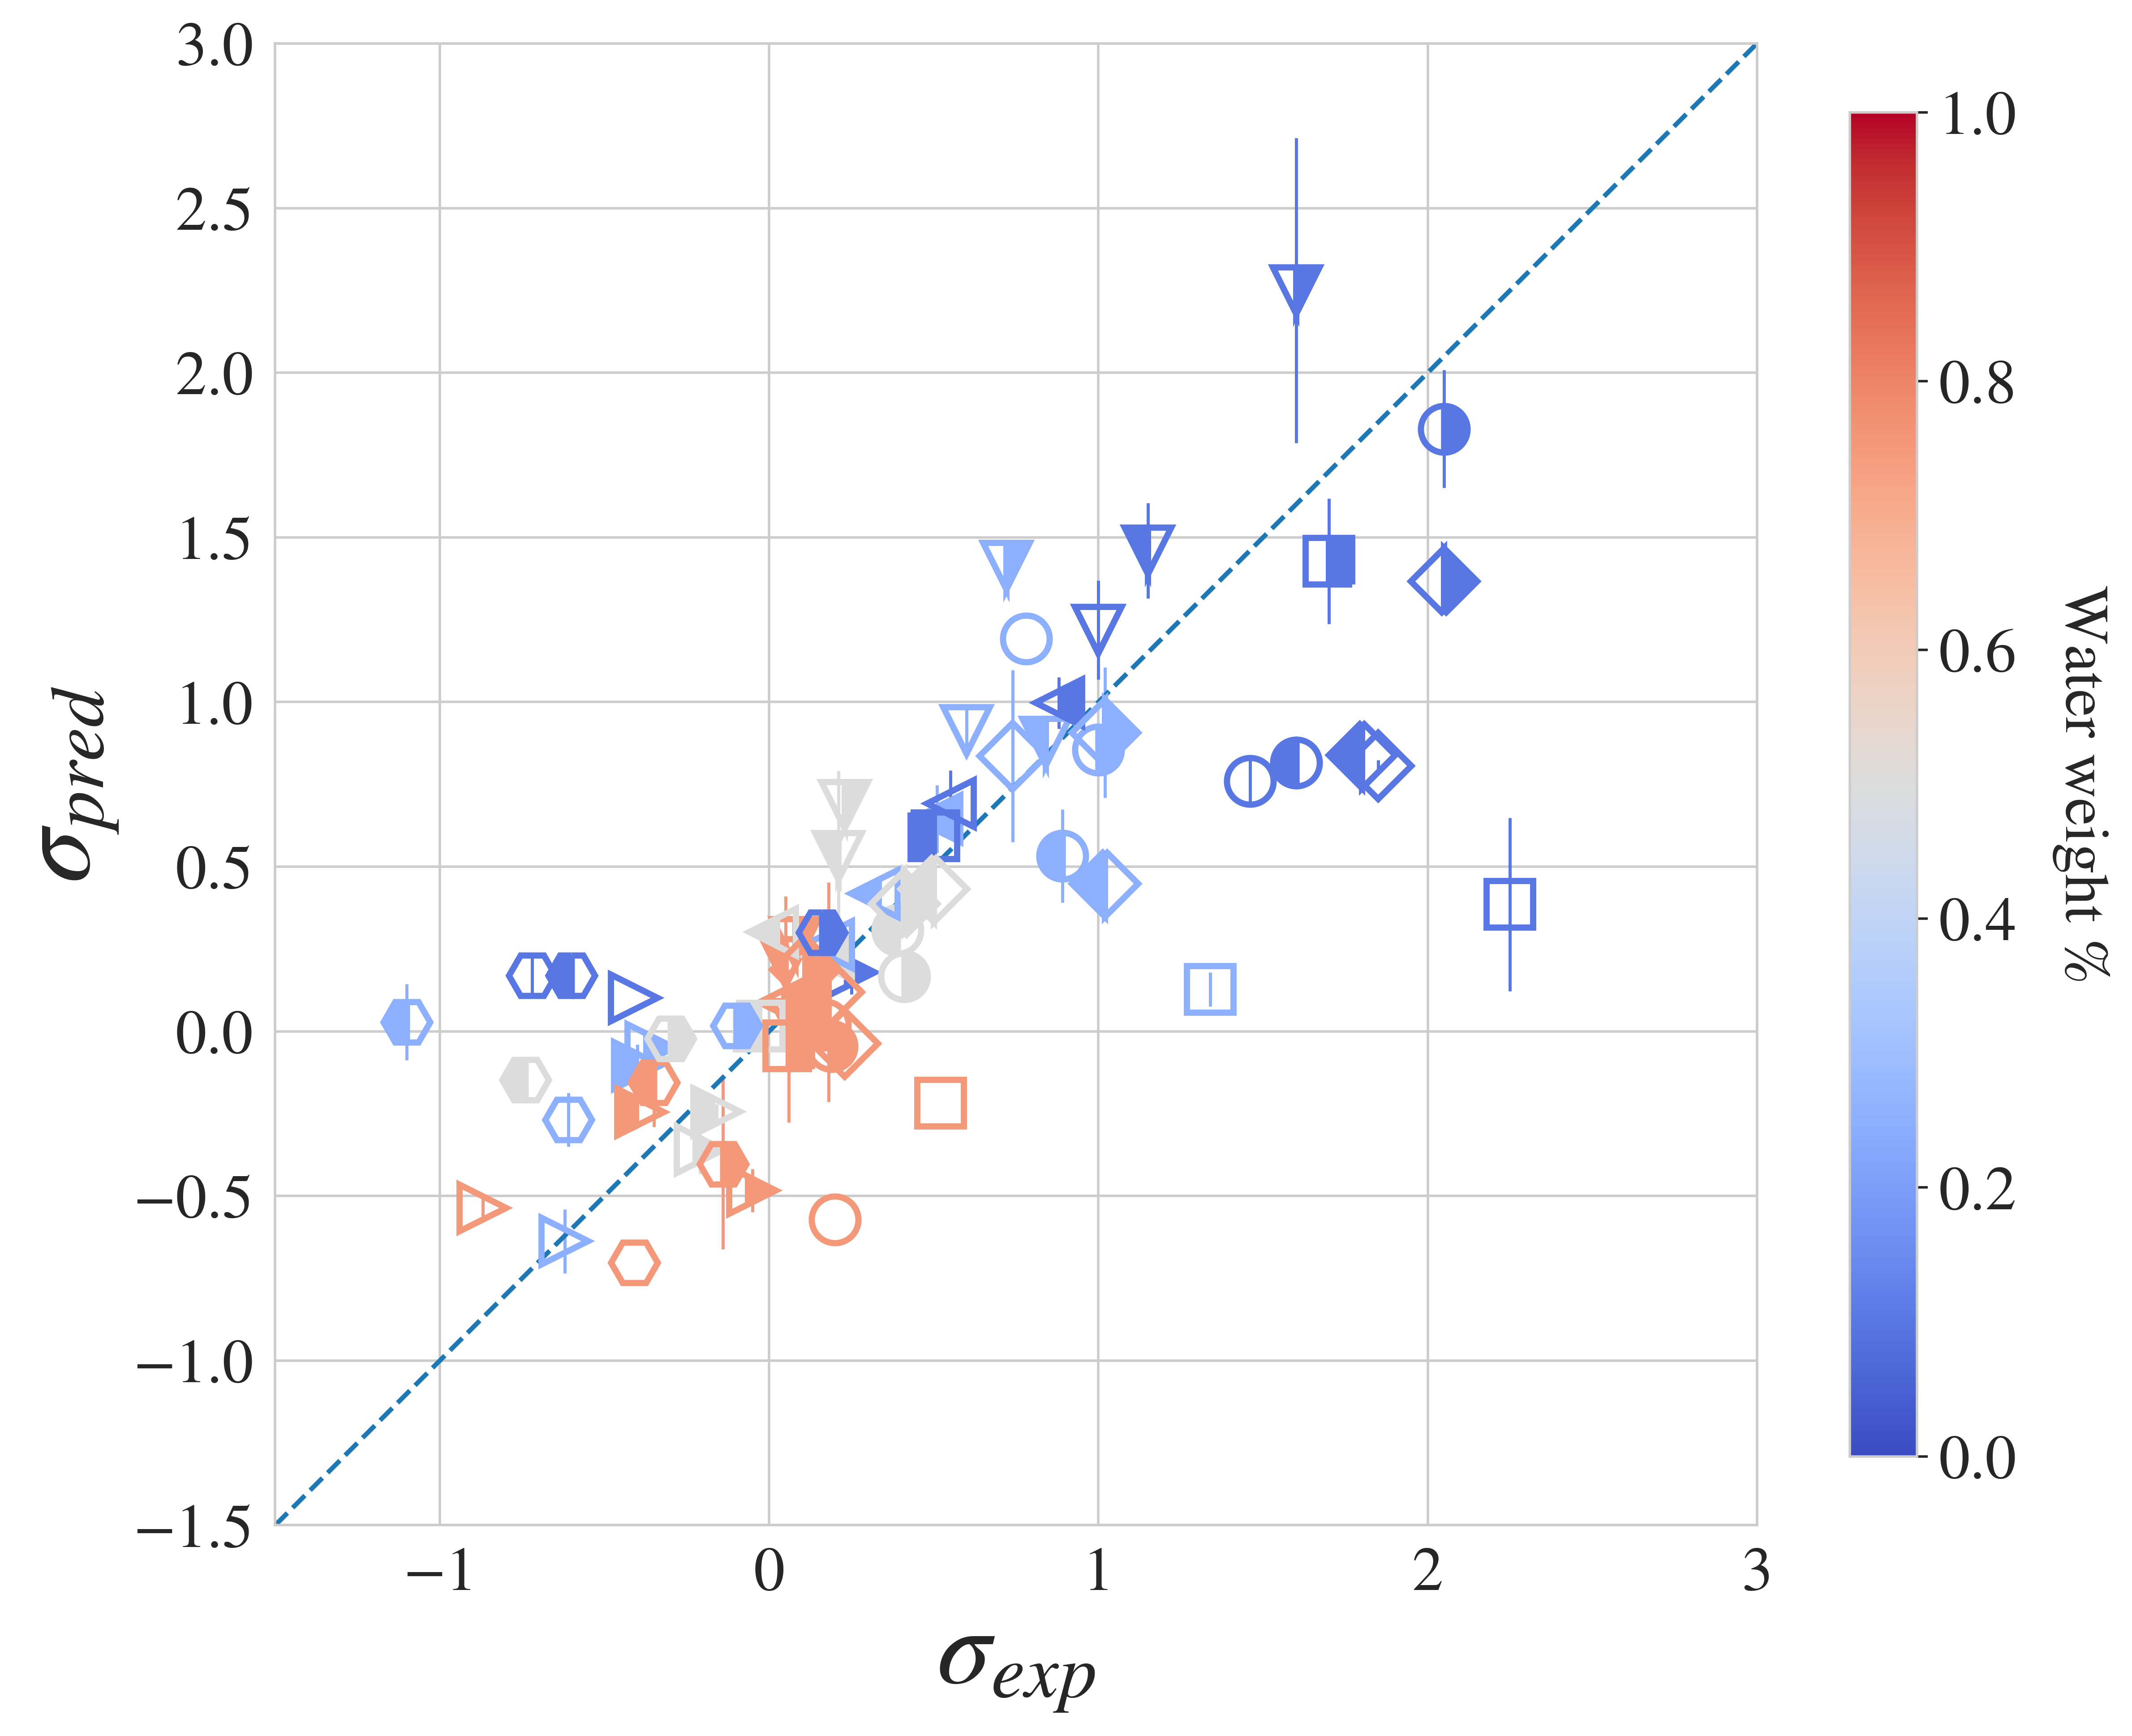

In [16]:
#Sort Data into different groups

cmap = matplotlib.cm.get_cmap('coolwarm')

from matplotlib.markers import MarkerStyle
plt.figure(figsize=(10, 10), dpi=500)

for i in range(len(descr_list)):
    
    if descr_list[i][1] == 'THF':
        fillstyle = 'none'
    elif descr_list[i][1] == 'GVL':
        fillstyle = 'right'
    elif descr_list[i][1] == 'DIO':
        fillstyle = 'left'
        
    if descr_list[i][0] == 'FRU':
        marker = MarkerStyle('o', fillstyle = fillstyle)
    elif descr_list[i][0] == 'CEL':
        marker = MarkerStyle('v', fillstyle = fillstyle)
    elif descr_list[i][0] == 'ETBE':
        marker = MarkerStyle('>', fillstyle = fillstyle)
    elif descr_list[i][0] == 'LGA':
        marker = MarkerStyle('<', fillstyle = fillstyle)
    elif descr_list[i][0] == 'PDO':
        marker = MarkerStyle('s', fillstyle = fillstyle)
    elif descr_list[i][0] == 'XYL':
        marker = MarkerStyle('D', fillstyle = fillstyle)
    elif descr_list[i][0] == 'tBuOH':
        marker = MarkerStyle('H', fillstyle = fillstyle)
        
    if descr_list[i][2] == '10':
        c = cmap(.1)
    elif descr_list[i][2] == '12':
        c = cmap(.12)
    elif descr_list[i][2] == '25':
        c = cmap(.25)
    elif descr_list[i][2] == '35':
        c = cmap(.35)
    elif descr_list[i][2] == '50':
        c = cmap(.5)
    elif descr_list[i][2] == '56':
        c = cmap(.56)
    elif descr_list[i][2] == '75':
        c = cmap(.75)
    
    plt.errorbar(label_val[i],mean_val[i],yerr = std_val[i],linewidth = 1,c = c,marker = marker,linestyle='',markersize = 15, markeredgewidth = 2)
    
plt.xlabel(r"$\sigma_{exp}$",fontsize = 35)
plt.ylabel(r"$\sigma_{pred}$",fontsize = 35)

plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)
plt.gca().set_aspect('equal', adjustable='box')


plt.plot([-1.5,3],[-1.5,3],'--')

norm = matplotlib.colors.Normalize(vmin=0,vmax=1)

cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),shrink=0.65)

cbar.ax.get_yaxis().labelpad = 30

cbar.ax.set_ylabel('Water weight %', rotation=270)

# plt.savefig("train_reg.svg")


In [17]:
mdl.fit(alldata,labelz)

a = mdl.predict(talldata)

In [18]:
rmse = np.mean((tlabelz - a)**2)
rmse

0.343340298534802

In [19]:
descrip_test = np.vstack([test_solutes,test_cosolvents,test_water_percent]).T

In [20]:
mean_val = []
std_val = []
label_val = []
descrip = []

for i in range(32):
    mean_val.append(np.mean(a[i*10:(i+1)*10]))
    std_val.append(np.std(a[i*10:(i+1)*10]))
    label_val.append(np.mean(tlabelz[i*10:(i+1)*10]))
    descrip.append(descrip_test[i*10])

Text(0, 0.5, 'Water weight %')

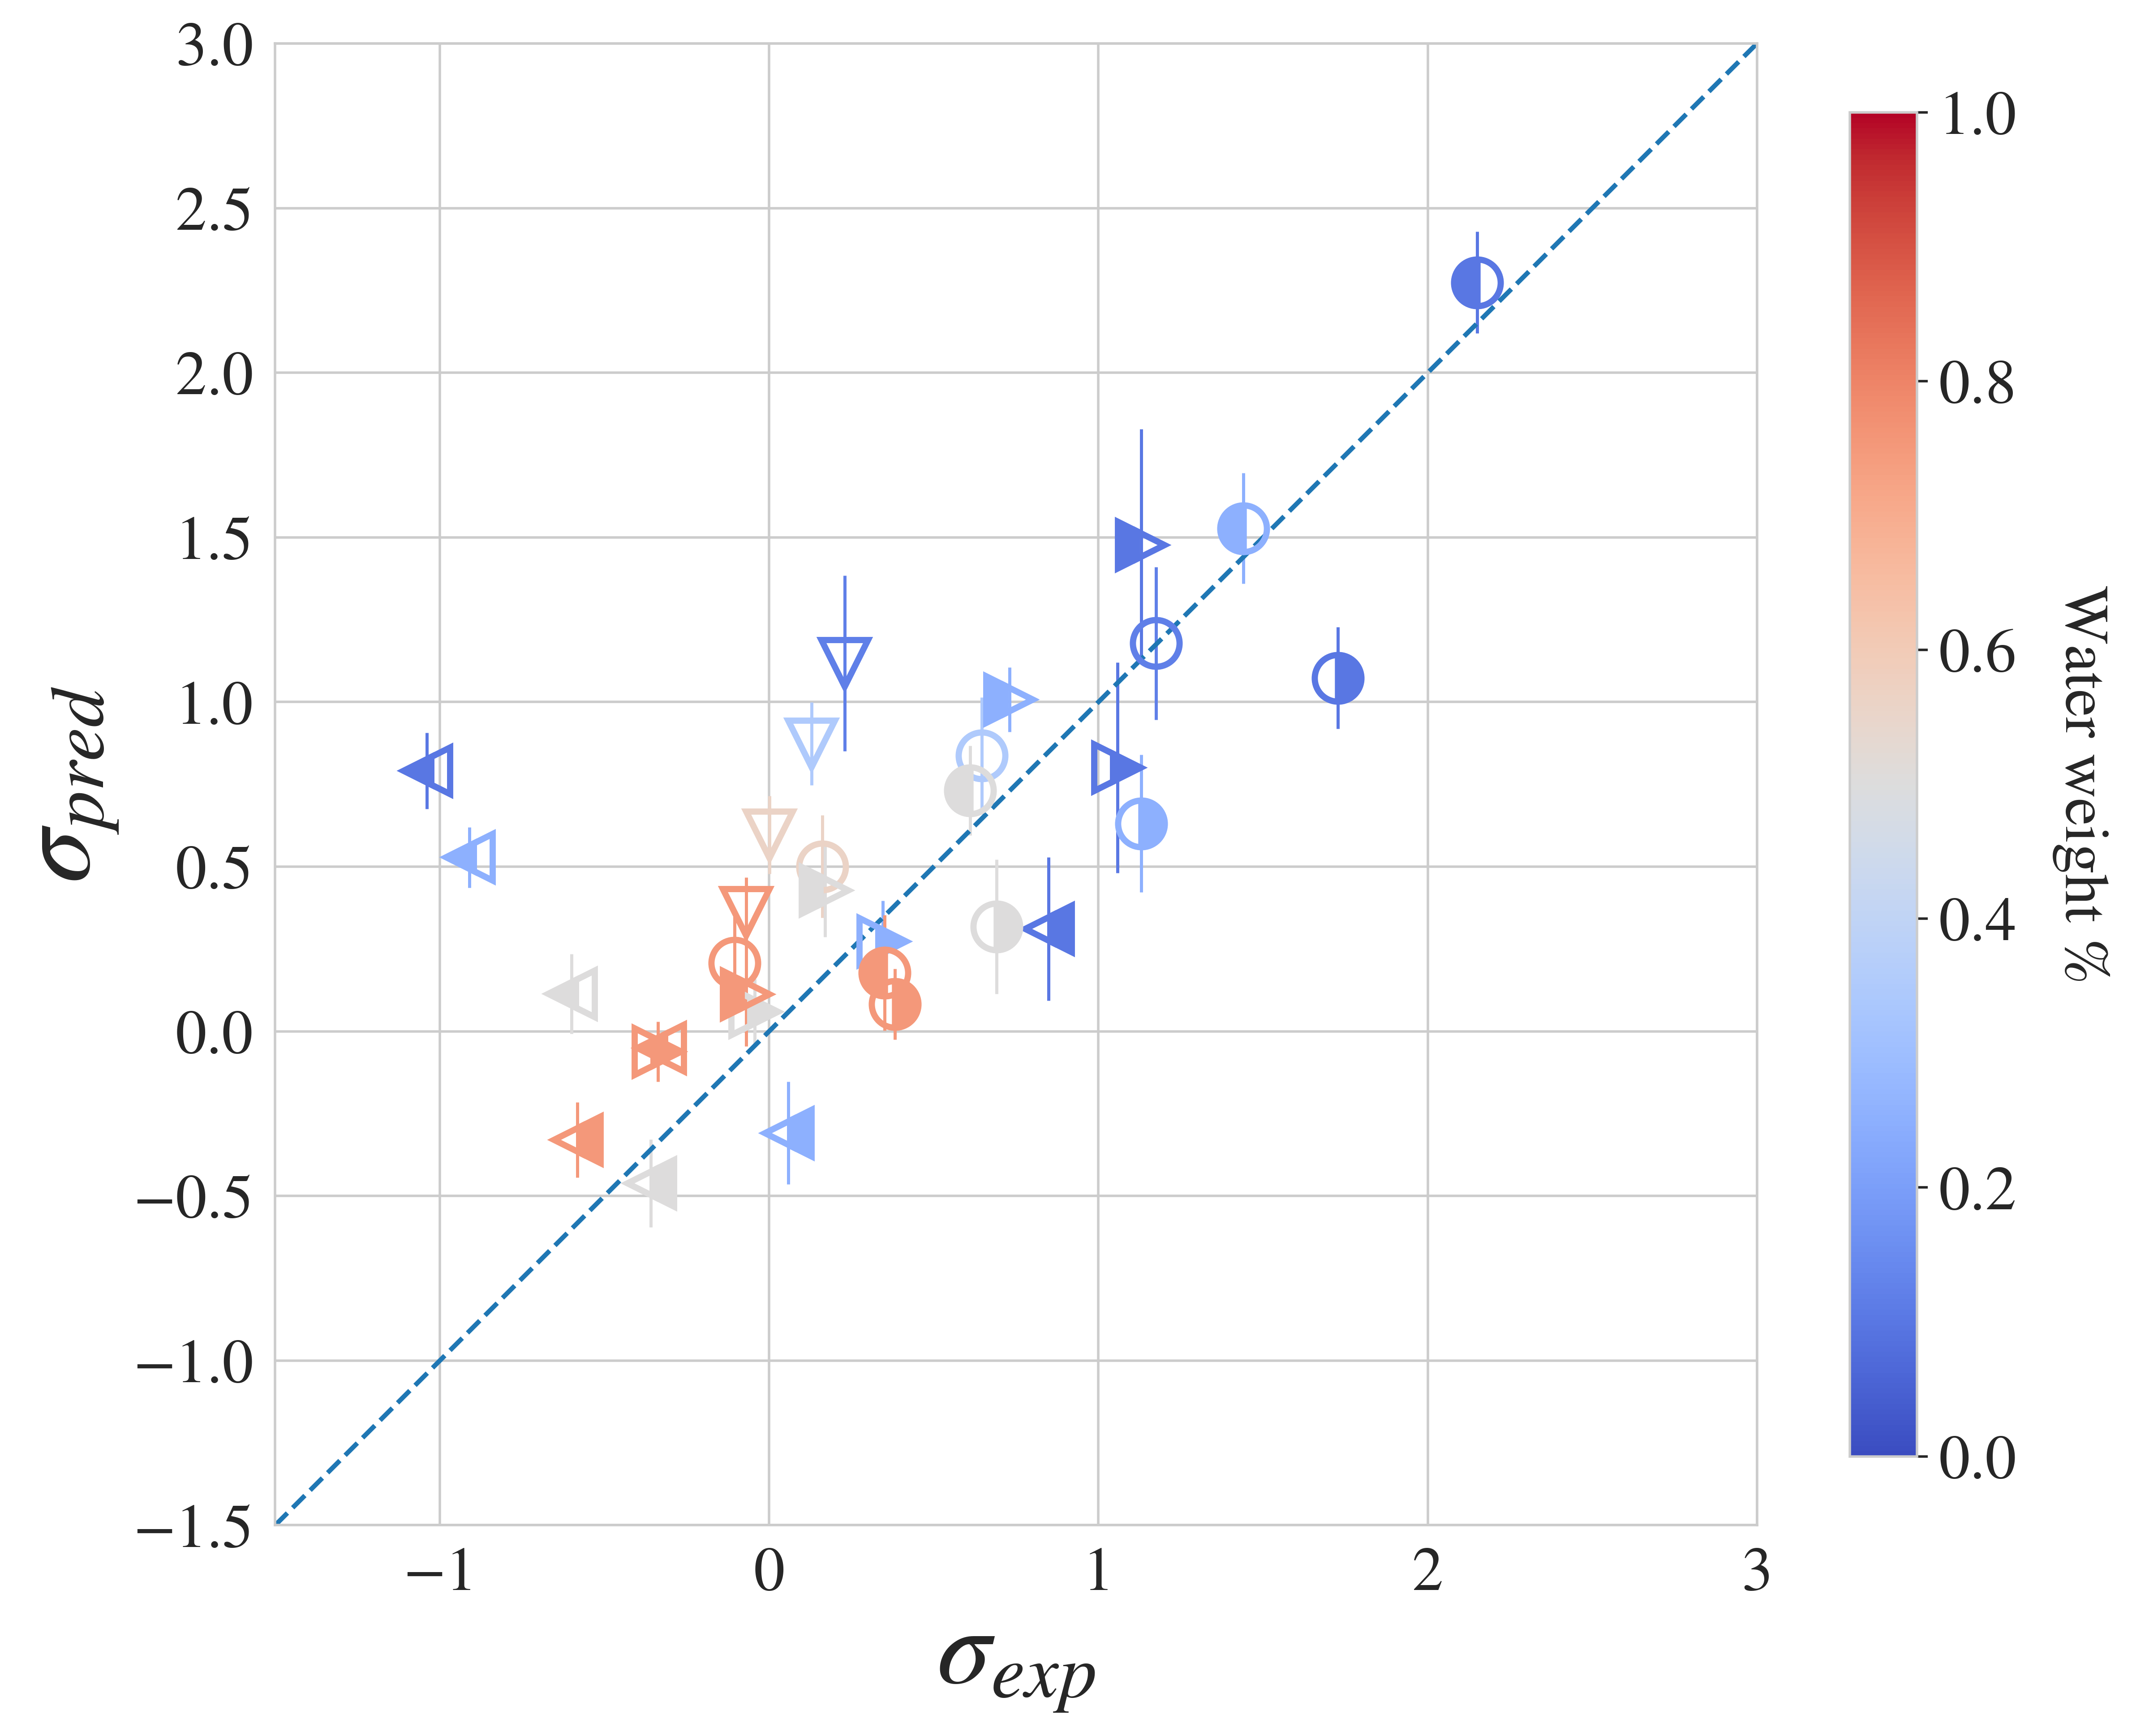

In [21]:
from matplotlib.markers import MarkerStyle
plt.figure(figsize=(10, 10), dpi=500)

cmap = matplotlib.cm.get_cmap('coolwarm')

for i in range(32):
        
    if descrip[i][1] == 'ACE':
        fillstyle = 'none'
    elif descrip[i][1] == 'ACN':
        fillstyle="right"
    elif descrip[i][1] == 'dmso':
        fillstyle="left"
        
    if descrip[i][0] == 'FRU':
        marker = MarkerStyle('o', fillstyle = fillstyle)
    elif descrip[i][0] == 'GLU':
        marker = MarkerStyle('v', fillstyle = fillstyle)
    elif descrip[i][0] == 'PDO':
        marker = MarkerStyle('>', fillstyle = fillstyle)
    else:
        marker = MarkerStyle('<', fillstyle = fillstyle)
        
    if descrip[i][2] == '10':
        c = cmap(0.1)
    elif descrip[i][2] == '12':
        c = cmap(.12)
    elif descrip[i][2] == '25':
        c = cmap(.25)
    elif descrip[i][2] == '35':
        c = cmap(.35)
    elif descrip[i][2] == '50':
        c = cmap(.5)
    elif descrip[i][2] == '56':
        c = cmap(.56)
    elif descrip[i][2] == '75':
        c = cmap(.75)
    
    plt.errorbar(label_val[i],mean_val[i],yerr = std_val[i],linewidth = 1,c = c,marker = marker,linestyle='',markersize = 15, markeredgewidth = 2)
    
plt.xlabel(r"$\sigma_{exp}$",fontsize = 35)
plt.ylabel(r"$\sigma_{pred}$",fontsize = 35)

plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)
plt.gca().set_aspect('equal', adjustable='box')


plt.plot([-1.5,3],[-1.5,3],'--')

norm = matplotlib.colors.Normalize(vmin=0,vmax=1)

cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),shrink=0.65)

cbar.ax.get_yaxis().labelpad = 30

cbar.ax.set_ylabel('Water weight %', rotation=270)

# plt.savefig("test_reg.svg")

In [22]:
mdl.coef_[-6::]

array([ 1.81615517e-04, -2.93971575e-02, -1.67095941e-01,  1.08203221e+00,
        5.70983973e-01, -3.86009921e-01])